In [1]:
initial_path = 'peptide-QML'
# initial_path = '..'

In [2]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import helper_classes as c
from my_code import pytorch_model as m

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
# name of the notebook
name_notebook = "sweep_12c_e_v2"

In [4]:
# sweep = c.Sweep(
#     name_notebook, 
#     initial_path=initial_path,
#     description="To compare with sweep_12h_e_Am_Xqm (now the same number of qubits/neurons) with a classical model with the same number of parameters.",
#     repetitions=list(range(1, 3)),
#     n_layers_block=[1,2,5,12,20],
#     embedding_dim=[1,5],
# )

In [5]:
# sweep.save()

In [6]:
sweep = c.Sweep.load(file_name=name_notebook+"-1", day='0914', initial_path=initial_path)



 --- SWEEP POINT 1/20: (1, 1, 1) ---
 --- parameters sweeping: ['repetitions', 'n_layers_block', 'embedding_dim'] 

12 4
Epoch [0/2], Loss epoch: 0.8231, Loss validation: 0.8236
	 Validation string, 	 i: 2628; 	 prediction: -0.3622, 	 target: -0.2890, 	 loss: 0.0054
	 Validation string, 	 i: 1712; 	 prediction: -0.3232, 	 target: -0.3073, 	 loss: 0.0003
	 Validation string, 	 i: 803; 	 prediction: -0.4262, 	 target: -0.4325, 	 loss: 0.0000
Epoch [1/2], Loss epoch: 0.0087, Loss validation: 0.0080, Time remaining: ~0.0h 0.0m 18s
	 Validation string, 	 i: 1855; 	 prediction: -0.4181, 	 target: -0.4453, 	 loss: 0.0007
	 Validation string, 	 i: 4115; 	 prediction: -0.1411, 	 target: -0.2249, 	 loss: 0.0070
	 Validation string, 	 i: 2041; 	 prediction: -0.2685, 	 target: -0.3041, 	 loss: 0.0013
Epoch [2/2], Loss epoch: 0.0079, Loss validation: 0.0082, Time remaining: ~0.0h 0.0m 0s


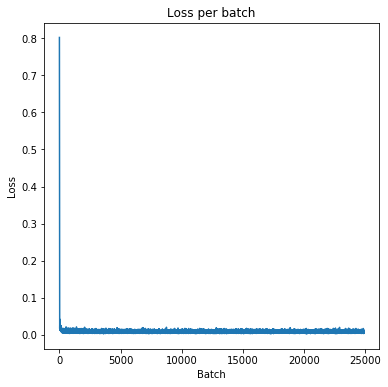

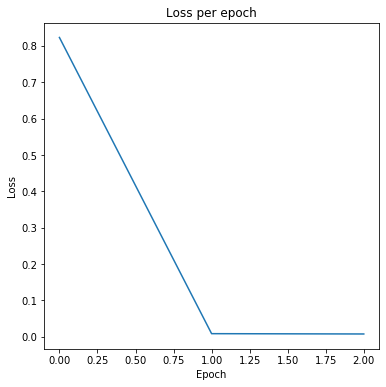

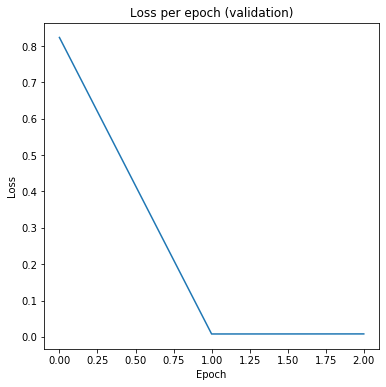

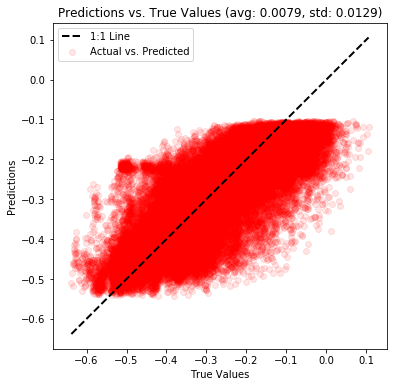

Mean loss: 0.007940161024239872, std loss: 0.012889835744674324


 --- SWEEP POINT 2/20: (1, 1, 5) ---
 --- time reamining: 04:20:17.73 

60 6
Epoch [0/2], Loss epoch: 0.0355, Loss validation: 0.0355


In [7]:
for sweep_point in sweep:

    # print the point of the sweep
    sweep.print_sweep_status(sweep_point['idx'])

    # -- MODEL -- #
                    
    class Model(m.Model):
        def __init__(self):
            super(Model, self).__init__()
            self.fc1 = m.nn.Embedding(num_embeddings=19, embedding_dim=sweep_point['embedding_dim'])
            self.fc2 = m.Reshape()
            dim_block = 4 if sweep_point['embedding_dim'] == 1 else 6
            block = [m.nn.Linear(12*sweep_point['embedding_dim'], dim_block), m.nn.Sigmoid()]
            block += [m.nn.Linear(dim_block, dim_block), m.nn.Sigmoid()] * sweep_point['n_layers_block']
            self.fc3 = m.nn.Sequential(*block)
            self.fc4 = m.nn.Linear(dim_block, 1) 

        def forward(self, x):
            for i in range(1,5):
                x = getattr(self, 'fc{}'.format(i))(x)
            return x

    model = Model()

    # set quantum layer
    quantum_layer = None
    model.set_quantum_layer(quantum_layer)

    # set the name and path of the model
    model.set_name_and_path(name_notebook, initial_path)

    #set sweep point
    model.set_sweep_point(
        sweep_uuid = sweep.uuid,
        sweep_point = sweep_point,
        day=sweep.day
    )

    # -- TRAIN -- #
    model.optimize_params(
        #save info
        save_model_info = True,
        description = 'sweep with 12 amino acids all classical -> to compare with sweep_12h_e_Am_Xqm',    
        #data
        data=c.Data.load(initial_path=initial_path, file_name='PET_SCORES_12_Numbers_int'),
        # train options
        optimizer = m.optim.Adam,
        optimizer_options = {'lr': 0.01},
        num_epochs = 2,                
        batch_size = 32,
        # early stopping options
        stop_training_options = {
            'lookback_epochs': 5, 
            'threshold_slope': 0.001,
            'threshold_std_dev': 0.2
        },
        # metadata
        metadata = {}
    )

    # -- VALIDATION and PLOTS -- #
    model.plot_losses(fig_size=(6,6))
    model.validate(
        pct=1,
        add_to_results=True,
        plot=True,
        print_items=False
    )

    # -- SAVE RESULTS -- #
    model.save_results()

    # -- ADD DATA GENERATED TO SWEEP -- #
    sweep.add_data(
        idx=sweep_point['idx'],
        model_uuid=model.uuid,
        best_loss_train=model.results.loss_epoch.best,
        best_loss_test=model.results.loss_validation_epoch.best,
        loss_validation=model.mean_loss_validation,
        time_train=model.results.time_epoch.last,
    )
    sweep.save(csv=False) #TODO: save csv=False automatically when sweep is already saved ion csv

    